# Predict and Eliminate Epidemic with Historical Data
Doris Lee (617001187)

In [1]:
# Must be included at the beginning of each new notebook. App name: BDAS-dengue
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('BDAS-dengue').getOrCreate()

In [2]:
# Read csv file saved from Steps 2-4 (dengue-integrated.csv). Schema is automatically configured.
data = spark.read.csv('dengue-integrated.csv', header=True, inferSchema=True)

In [3]:
# Print the schema of the DataFrame
data.printSchema()

root
 |-- city: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- weekofyear: integer (nullable = true)
 |-- ndvi_ne: double (nullable = true)
 |-- ndvi_nw: double (nullable = true)
 |-- ndvi_se: double (nullable = true)
 |-- ndvi_sw: double (nullable = true)
 |-- precipitation_amt_mm: double (nullable = true)
 |-- reanalysis_air_temp_k: double (nullable = true)
 |-- reanalysis_avg_temp_k: double (nullable = true)
 |-- reanalysis_dew_point_temp_k: double (nullable = true)
 |-- reanalysis_max_air_temp_k: double (nullable = true)
 |-- reanalysis_min_air_temp_k: double (nullable = true)
 |-- reanalysis_precip_amt_kg_per_m2: double (nullable = true)
 |-- reanalysis_relative_humidity_percent: double (nullable = true)
 |-- reanalysis_sat_precip_amt_mm: double (nullable = true)
 |-- reanalysis_specific_humidity_g_per_kg: double (nullable = true)
 |-- reanalysis_tdtr_k: double (nullable = true)
 |-- station_avg_temp_c: double (nullable = true)
 |-- station_diur_temp_rng_c: dou

In [4]:
# Print number of rows and columns in data
print(data.count())
print(len(data.columns))

1110
32


## 6. Data Mining Algorithm(s) Selection

### 6.3 Building appropriate model(s) with relevant parameter(s)

#### 6.3.1 Building appropriate models

In [5]:
# Import DecisionTreeClassifier
from pyspark.ml.classification import DecisionTreeClassifier, LogisticRegression, OneVsRest, GBTClassifier
# Import LinearRegression
from pyspark.ml.regression import LinearRegression, GeneralizedLinearRegression, GBTRegressor

#### 6.3.2 First iteration – selecting relevant features

In [6]:
# Import VectorAssembler and Vectors
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [7]:
# Assemble features vector with the nine features identified in step 4.1 Data Reduction
assembler = VectorAssembler(
    inputCols=['reanalysis_min_air_temp_k', 'reanalysis_tdtr_k', 'station_diur_temp_rng_c', 'reanalysis_max_air_temp_k', 'station_min_temp_c', 'reanalysis_air_temp_k', 'ndvi_ne', 'ndvi_nw'],
    outputCol="features")

In [8]:
# Transform the data using the vector assembler
output1 = assembler.transform(data)

In [9]:
# Check if features column is added to output
output1.printSchema()
# Check that the features column is a dense vector that combines the various features as expected
output1.head(1)

root
 |-- city: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- weekofyear: integer (nullable = true)
 |-- ndvi_ne: double (nullable = true)
 |-- ndvi_nw: double (nullable = true)
 |-- ndvi_se: double (nullable = true)
 |-- ndvi_sw: double (nullable = true)
 |-- precipitation_amt_mm: double (nullable = true)
 |-- reanalysis_air_temp_k: double (nullable = true)
 |-- reanalysis_avg_temp_k: double (nullable = true)
 |-- reanalysis_dew_point_temp_k: double (nullable = true)
 |-- reanalysis_max_air_temp_k: double (nullable = true)
 |-- reanalysis_min_air_temp_k: double (nullable = true)
 |-- reanalysis_precip_amt_kg_per_m2: double (nullable = true)
 |-- reanalysis_relative_humidity_percent: double (nullable = true)
 |-- reanalysis_sat_precip_amt_mm: double (nullable = true)
 |-- reanalysis_specific_humidity_g_per_kg: double (nullable = true)
 |-- reanalysis_tdtr_k: double (nullable = true)
 |-- station_avg_temp_c: double (nullable = true)
 |-- station_diur_temp_rng_c: dou

[Row(city='sj', year=1990, weekofyear=18, ndvi_ne=0.1226, ndvi_nw=0.103725, ndvi_se=0.1984833, ndvi_sw=0.1776167, precipitation_amt_mm=12.42, reanalysis_air_temp_k=297.572857143, reanalysis_avg_temp_k=297.742857143, reanalysis_dew_point_temp_k=292.414285714, reanalysis_max_air_temp_k=299.8, reanalysis_min_air_temp_k=295.9, reanalysis_precip_amt_kg_per_m2=32.0, reanalysis_relative_humidity_percent=73.3657142857, reanalysis_sat_precip_amt_mm=12.42, reanalysis_specific_humidity_g_per_kg=14.0128571429, reanalysis_tdtr_k=2.62857142857, station_avg_temp_c=25.4428571429, station_diur_temp_rng_c=6.9, station_max_temp_c=29.4, station_min_temp_c=20.0, station_precip_mm=16.0, total_cases=4, total_cases_double=4.0, total_cases_bin=0, log_reanalysis_precip_amt_kg_per_m2=3.4965075614664802, log_station_precip_mm=2.833213344056216, log_precipitation_amt_mm=2.5967461315435356, log_reanalysis_sat_precip_amt_mm=2.5967461315435356, log_reanalysis_tdtr_k=1.2888390249687838, log_total_cases=1.6094379124341

#### 6.3.3 Second iteration – selecting relevant features

In [10]:
# Assemble features vector with the ten features identified in step 4.1 Data Reduction
assembler = VectorAssembler(
    inputCols=['log_reanalysis_tdtr_k', 'reanalysis_min_air_temp_k', 'station_diur_temp_rng_c', 'reanalysis_max_air_temp_k', 'ndvi_ne', 'station_min_temp_c', 'ndvi_nw', 'ndvi_sw', 'reanalysis_air_temp_k', 'ndvi_se'],
    outputCol="features")

In [11]:
# Transform the data using the vector assembler
output2 = assembler.transform(data)

In [12]:
# Check if features column is added to output
output2.printSchema()
# Check that the features column is a dense vector that combines the various features as expected
output2.head(1)

root
 |-- city: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- weekofyear: integer (nullable = true)
 |-- ndvi_ne: double (nullable = true)
 |-- ndvi_nw: double (nullable = true)
 |-- ndvi_se: double (nullable = true)
 |-- ndvi_sw: double (nullable = true)
 |-- precipitation_amt_mm: double (nullable = true)
 |-- reanalysis_air_temp_k: double (nullable = true)
 |-- reanalysis_avg_temp_k: double (nullable = true)
 |-- reanalysis_dew_point_temp_k: double (nullable = true)
 |-- reanalysis_max_air_temp_k: double (nullable = true)
 |-- reanalysis_min_air_temp_k: double (nullable = true)
 |-- reanalysis_precip_amt_kg_per_m2: double (nullable = true)
 |-- reanalysis_relative_humidity_percent: double (nullable = true)
 |-- reanalysis_sat_precip_amt_mm: double (nullable = true)
 |-- reanalysis_specific_humidity_g_per_kg: double (nullable = true)
 |-- reanalysis_tdtr_k: double (nullable = true)
 |-- station_avg_temp_c: double (nullable = true)
 |-- station_diur_temp_rng_c: dou

[Row(city='sj', year=1990, weekofyear=18, ndvi_ne=0.1226, ndvi_nw=0.103725, ndvi_se=0.1984833, ndvi_sw=0.1776167, precipitation_amt_mm=12.42, reanalysis_air_temp_k=297.572857143, reanalysis_avg_temp_k=297.742857143, reanalysis_dew_point_temp_k=292.414285714, reanalysis_max_air_temp_k=299.8, reanalysis_min_air_temp_k=295.9, reanalysis_precip_amt_kg_per_m2=32.0, reanalysis_relative_humidity_percent=73.3657142857, reanalysis_sat_precip_amt_mm=12.42, reanalysis_specific_humidity_g_per_kg=14.0128571429, reanalysis_tdtr_k=2.62857142857, station_avg_temp_c=25.4428571429, station_diur_temp_rng_c=6.9, station_max_temp_c=29.4, station_min_temp_c=20.0, station_precip_mm=16.0, total_cases=4, total_cases_double=4.0, total_cases_bin=0, log_reanalysis_precip_amt_kg_per_m2=3.4965075614664802, log_station_precip_mm=2.833213344056216, log_precipitation_amt_mm=2.5967461315435356, log_reanalysis_sat_precip_amt_mm=2.5967461315435356, log_reanalysis_tdtr_k=1.2888390249687838, log_total_cases=1.6094379124341

#### 6.3.4 Third iteration – selecting relevant features

In [13]:
# Assemble features vector with the features from Reanalysis only
assembler = VectorAssembler(
    inputCols=['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'reanalysis_air_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'log_reanalysis_tdtr_k'],
    outputCol="features")
# Transform the data using the vector assembler
output3r = assembler.transform(data)
# Check that the features column is a dense vector that combines the various features as expected
output3r.head(1)

[Row(city='sj', year=1990, weekofyear=18, ndvi_ne=0.1226, ndvi_nw=0.103725, ndvi_se=0.1984833, ndvi_sw=0.1776167, precipitation_amt_mm=12.42, reanalysis_air_temp_k=297.572857143, reanalysis_avg_temp_k=297.742857143, reanalysis_dew_point_temp_k=292.414285714, reanalysis_max_air_temp_k=299.8, reanalysis_min_air_temp_k=295.9, reanalysis_precip_amt_kg_per_m2=32.0, reanalysis_relative_humidity_percent=73.3657142857, reanalysis_sat_precip_amt_mm=12.42, reanalysis_specific_humidity_g_per_kg=14.0128571429, reanalysis_tdtr_k=2.62857142857, station_avg_temp_c=25.4428571429, station_diur_temp_rng_c=6.9, station_max_temp_c=29.4, station_min_temp_c=20.0, station_precip_mm=16.0, total_cases=4, total_cases_double=4.0, total_cases_bin=0, log_reanalysis_precip_amt_kg_per_m2=3.4965075614664802, log_station_precip_mm=2.833213344056216, log_precipitation_amt_mm=2.5967461315435356, log_reanalysis_sat_precip_amt_mm=2.5967461315435356, log_reanalysis_tdtr_k=1.2888390249687838, log_total_cases=1.6094379124341

In [14]:
# Assemble features vector with the features from weather stations only
assembler = VectorAssembler(
    inputCols=['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'station_diur_temp_rng_c', 'station_min_temp_c'],
    outputCol="features")
# Transform the data using the vector assembler
output3s = assembler.transform(data)
# Check that the features column is a dense vector that combines the various features as expected
output3s.head(1)

[Row(city='sj', year=1990, weekofyear=18, ndvi_ne=0.1226, ndvi_nw=0.103725, ndvi_se=0.1984833, ndvi_sw=0.1776167, precipitation_amt_mm=12.42, reanalysis_air_temp_k=297.572857143, reanalysis_avg_temp_k=297.742857143, reanalysis_dew_point_temp_k=292.414285714, reanalysis_max_air_temp_k=299.8, reanalysis_min_air_temp_k=295.9, reanalysis_precip_amt_kg_per_m2=32.0, reanalysis_relative_humidity_percent=73.3657142857, reanalysis_sat_precip_amt_mm=12.42, reanalysis_specific_humidity_g_per_kg=14.0128571429, reanalysis_tdtr_k=2.62857142857, station_avg_temp_c=25.4428571429, station_diur_temp_rng_c=6.9, station_max_temp_c=29.4, station_min_temp_c=20.0, station_precip_mm=16.0, total_cases=4, total_cases_double=4.0, total_cases_bin=0, log_reanalysis_precip_amt_kg_per_m2=3.4965075614664802, log_station_precip_mm=2.833213344056216, log_precipitation_amt_mm=2.5967461315435356, log_reanalysis_sat_precip_amt_mm=2.5967461315435356, log_reanalysis_tdtr_k=1.2888390249687838, log_total_cases=1.6094379124341

## 7. Data Mining

### 7.1 Creating and justifying test designs

#### 7.1.1 First iteration – partitioning

In [15]:
# Select the features and predictor (total_cases_bin) columns for classification
final_data_classify_1 = output1.select("features",'total_cases_bin')
final_data_classify_1.show()

+--------------------+---------------+
|            features|total_cases_bin|
+--------------------+---------------+
|[295.9,2.62857142...|              0|
|[296.4,2.37142857...|              0|
|[297.3,2.3,6.4857...|              0|
|[297.0,2.42857142...|              0|
|[297.5,3.01428571...|              0|
|[297.7,2.04285714...|              0|
|[298.4,1.57142857...|              0|
|[297.7,1.88571428...|              1|
|[298.0,2.15714285...|              0|
|[297.3,2.41428571...|              0|
|[297.1,2.07142857...|              0|
|[298.1,2.48571428...|              1|
|[298.7,1.9,6.5285...|              1|
|[298.0,3.47142857...|              1|
|[299.0,2.9,8.0571...|              1|
|[298.7,1.74285714...|              1|
|[299.1,2.25714285...|              1|
|[299.1,2.9,8.0285...|              1|
|[298.1,2.57142857...|              1|
|[297.2,1.8,7.6285...|              1|
+--------------------+---------------+
only showing top 20 rows



In [16]:
# Split dataset into 80% train and 20% test
train_data_classify_1,test_data_classify_1 = final_data_classify_1.randomSplit([0.8,0.2])

In [17]:
# Check training data
train_data_classify_1.describe().show()
# Check testing data
test_data_classify_1.describe().show()

+-------+-------------------+
|summary|    total_cases_bin|
+-------+-------------------+
|  count|                884|
|   mean|0.49660633484162897|
| stddev| 0.5002715219774297|
|    min|                  0|
|    max|                  1|
+-------+-------------------+

+-------+------------------+
|summary|   total_cases_bin|
+-------+------------------+
|  count|               226|
|   mean|0.5221238938053098|
| stddev| 0.500619085759371|
|    min|                 0|
|    max|                 1|
+-------+------------------+



In [18]:
# Select the features and predictor (total_cases) columns for regression
final_data_regress_1 = output1.select("features",'total_cases')
final_data_regress_1.show()

+--------------------+-----------+
|            features|total_cases|
+--------------------+-----------+
|[295.9,2.62857142...|          4|
|[296.4,2.37142857...|          5|
|[297.3,2.3,6.4857...|          4|
|[297.0,2.42857142...|          3|
|[297.5,3.01428571...|          6|
|[297.7,2.04285714...|          4|
|[298.4,1.57142857...|          5|
|[297.7,1.88571428...|         10|
|[298.0,2.15714285...|          8|
|[297.3,2.41428571...|          2|
|[297.1,2.07142857...|          6|
|[298.1,2.48571428...|         21|
|[298.7,1.9,6.5285...|         28|
|[298.0,3.47142857...|         24|
|[299.0,2.9,8.0571...|         20|
|[298.7,1.74285714...|         40|
|[299.1,2.25714285...|         27|
|[299.1,2.9,8.0285...|         42|
|[298.1,2.57142857...|         33|
|[297.2,1.8,7.6285...|         37|
+--------------------+-----------+
only showing top 20 rows



In [19]:
# Split dataset into 80% train & 20% test
train_data_regress_1,test_data_regress_1 = final_data_regress_1.randomSplit([0.8,0.2])

In [20]:
# Check training data
train_data_regress_1.describe().show()
# Check testing data
test_data_regress_1.describe().show()

+-------+------------------+
|summary|       total_cases|
+-------+------------------+
|  count|               865|
|   mean|14.196531791907514|
| stddev|13.635236113963586|
|    min|                 0|
|    max|                62|
+-------+------------------+

+-------+-----------------+
|summary|      total_cases|
+-------+-----------------+
|  count|              245|
|   mean|14.89795918367347|
| stddev|14.92473590116886|
|    min|                0|
|    max|               61|
+-------+-----------------+



#### 7.1.2 Second iteration – partitioning

In [21]:
# Select the features and predictor (total_cases_bin) columns for classification
final_data_classify_2 = output2.select("features",'total_cases_bin')
final_data_classify_2.show()

+--------------------+---------------+
|            features|total_cases_bin|
+--------------------+---------------+
|[1.28883902496878...|              0|
|[1.21533656297667...|              0|
|[1.19392246847243...|              0|
|[1.23214368129221...|              0|
|[1.38985942728545...|              0|
|[1.11279692366100...|              0|
|[0.94446160884140...|              0|
|[1.05977245535036...|              1|
|[1.14966745946748...|              0|
|[1.22796830988340...|              0|
|[1.12214278607876...|              0|
|[1.24867298324261...|              1|
|[1.06471073699242...|              1|
|[1.49770794849111...|              1|
|[1.36097655313560...|              1|
|[1.00900012997946...|              1|
|[1.18085038690420...|              1|
|[1.36097655313560...|              1|
|[1.27296567581328...|              1|
|[1.02961941718115...|              1|
+--------------------+---------------+
only showing top 20 rows



In [22]:
# Split dataset into 80% train & 20% test
train_data_classify_2,test_data_classify_2 = final_data_classify_2.randomSplit([0.8,0.2])

In [23]:
# Check training data
train_data_classify_2.describe().show()
# Check testing data
test_data_classify_2.describe().show()

+-------+------------------+
|summary|   total_cases_bin|
+-------+------------------+
|  count|               874|
|   mean|0.4931350114416476|
| stddev|0.5002391296081529|
|    min|                 0|
|    max|                 1|
+-------+------------------+

+-------+------------------+
|summary|   total_cases_bin|
+-------+------------------+
|  count|               236|
|   mean|0.5338983050847458|
| stddev|0.4999098368038833|
|    min|                 0|
|    max|                 1|
+-------+------------------+



In [24]:
# Select the features and predictor (log_total_cases) columns for regression
final_data_regress_2 = output2.select("features",'log_total_cases')
final_data_regress_2.show()

+--------------------+------------------+
|            features|   log_total_cases|
+--------------------+------------------+
|[1.28883902496878...|1.6094379124341003|
|[1.21533656297667...| 1.791759469228055|
|[1.19392246847243...|1.6094379124341003|
|[1.23214368129221...|1.3862943611198906|
|[1.38985942728545...|1.9459101490553132|
|[1.11279692366100...|1.6094379124341003|
|[0.94446160884140...| 1.791759469228055|
|[1.05977245535036...|2.3978952727983707|
|[1.14966745946748...|2.1972245773362196|
|[1.22796830988340...|1.0986122886681098|
|[1.12214278607876...|1.9459101490553132|
|[1.24867298324261...| 3.091042453358316|
|[1.06471073699242...| 3.367295829986474|
|[1.49770794849111...|3.2188758248682006|
|[1.36097655313560...| 3.044522437723423|
|[1.00900012997946...| 3.713572066704308|
|[1.18085038690420...| 3.332204510175204|
|[1.36097655313560...|3.7612001156935624|
|[1.27296567581328...|3.5263605246161616|
|[1.02961941718115...|3.6375861597263857|
+--------------------+------------

In [25]:
# Split dataset into 80% train & 20% test
train_data_regress_2,test_data_regress_2 = final_data_regress_2.randomSplit([0.8,0.2])

In [26]:
# Check training data
train_data_regress_2.describe().show()
# Check testing data
test_data_regress_2.describe().show()

+-------+------------------+
|summary|   log_total_cases|
+-------+------------------+
|  count|               902|
|   mean|2.2395759294795248|
| stddev|1.0916918271615843|
|    min|               0.0|
|    max| 4.143134726391533|
+-------+------------------+

+-------+------------------+
|summary|   log_total_cases|
+-------+------------------+
|  count|               208|
|   mean| 2.309641220676066|
| stddev|1.0412405213226457|
|    min|               0.0|
|    max| 4.110873864173311|
+-------+------------------+



#### 7.1.3 Third iteration – partitioning

In [27]:
# Select the Reanalysis features and predictor (log_total_cases) columns for regression
final_data_regress_3r = output3r.select("features",'log_total_cases')
final_data_regress_3r.show(3)

+--------------------+------------------+
|            features|   log_total_cases|
+--------------------+------------------+
|[0.1226,0.103725,...|1.6094379124341003|
|[0.1699,0.142175,...| 1.791759469228055|
|[0.03225,0.172966...|1.6094379124341003|
+--------------------+------------------+
only showing top 3 rows



In [28]:
# Split dataset into 80% train & 20% test
train_data_regress_3r,test_data_regress_3r = final_data_regress_3r.randomSplit([0.8,0.2])

In [29]:
# Check training data
train_data_regress_3r.describe().show()
# Check testing data
test_data_regress_3r.describe().show()

+-------+------------------+
|summary|   log_total_cases|
+-------+------------------+
|  count|               886|
|   mean|2.2325879669936004|
| stddev|1.0797123823877879|
|    min|               0.0|
|    max| 4.143134726391533|
+-------+------------------+

+-------+------------------+
|summary|   log_total_cases|
+-------+------------------+
|  count|               224|
|   mean|2.3322764443518937|
| stddev|1.0912781518000692|
|    min|               0.0|
|    max| 4.110873864173311|
+-------+------------------+



In [30]:
# Select the weather station features and predictor (log_total_cases) columns for regression
final_data_regress_3s = output3s.select("features",'log_total_cases')
final_data_regress_3s.show(3)

+--------------------+------------------+
|            features|   log_total_cases|
+--------------------+------------------+
|[0.1226,0.103725,...|1.6094379124341003|
|[0.1699,0.142175,...| 1.791759469228055|
|[0.03225,0.172966...|1.6094379124341003|
+--------------------+------------------+
only showing top 3 rows



In [31]:
# Split dataset into 80% train & 20% test
train_data_regress_3s,test_data_regress_3s = final_data_regress_3s.randomSplit([0.8,0.2])

In [32]:
# Check training data
train_data_regress_3s.describe().show()
# Check testing data
test_data_regress_3s.describe().show()

+-------+------------------+
|summary|   log_total_cases|
+-------+------------------+
|  count|               885|
|   mean| 2.249658445948913|
| stddev|1.0764332737728013|
|    min|               0.0|
|    max| 4.143134726391533|
+-------+------------------+

+-------+------------------+
|summary|   log_total_cases|
+-------+------------------+
|  count|               225|
|   mean|2.2646895005616257|
| stddev|1.1074427655939094|
|    min|               0.0|
|    max| 4.060443010546419|
+-------+------------------+



### 7.2 Conducting data mining

In [33]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator

#### 7.2.1 First iteration – data mining

In [34]:
# Decision Tree Classifier (first iteration)
dtc1 = DecisionTreeClassifier(labelCol='total_cases_bin',featuresCol='features')
dtc1_model = dtc1.fit(train_data_classify_1)
dtc1_predictions = dtc1_model.transform(test_data_classify_1)

In [35]:
# Compute accuracy
acc_evaluator = MulticlassClassificationEvaluator(labelCol="total_cases_bin", predictionCol="prediction", metricName="accuracy")
dtc1_acc = acc_evaluator.evaluate(dtc1_predictions)
print('Decision Tree has an accuracy of: {0:2.2f}%'.format(dtc1_acc*100))

Decision Tree has an accuracy of: 66.81%


In [36]:
# Logistic Regression (first iteration)
logreg1 = LogisticRegression(labelCol='total_cases_bin', featuresCol='features')
logreg1_model = logreg1.fit(train_data_classify_1)
logreg1_predictions = logreg1_model.transform(test_data_classify_1)

In [37]:
# Compute accuracy
acc_evaluator = MulticlassClassificationEvaluator(labelCol="total_cases_bin", predictionCol="prediction", metricName="accuracy")
logreg1_acc = acc_evaluator.evaluate(logreg1_predictions)
print('Logistic Regression has an accuracy of: {0:2.2f}%'.format(logreg1_acc*100))

Logistic Regression has an accuracy of: 72.57%


In [38]:
# OneVsRest (first iteration)
ovr_lr1 = LogisticRegression(maxIter=10, tol=1E-6, fitIntercept=True)
ovr1 = OneVsRest(classifier=ovr_lr1, labelCol='total_cases_bin', featuresCol='features')
ovr1_model = ovr1.fit(train_data_classify_1)
ovr1_predictions = ovr1_model.transform(test_data_classify_1)

In [39]:
# Compute accuracy
acc_evaluator = MulticlassClassificationEvaluator(labelCol="total_cases_bin", predictionCol="prediction", metricName="accuracy")
ovr1_acc = acc_evaluator.evaluate(ovr1_predictions)
print('OneVsRest has an accuracy of: {0:2.2f}%'.format(ovr1_acc*100))

OneVsRest has an accuracy of: 56.64%


In [40]:
# GBTClassifier (first iteration)
gbt1 = GBTClassifier(labelCol='total_cases_bin', featuresCol='features', maxIter=10)
gbt1_model = gbt1.fit(train_data_classify_1)
gbt1_predictions = gbt1_model.transform(test_data_classify_1)

In [41]:
# Compute accuracy
acc_evaluator = MulticlassClassificationEvaluator(labelCol="total_cases_bin", predictionCol="prediction", metricName="accuracy")
gbt1_acc = acc_evaluator.evaluate(gbt1_predictions)
print('GBTClassifier has an accuracy of: {0:2.2f}%'.format(gbt1_acc*100))

GBTClassifier has an accuracy of: 69.03%


In [42]:
# Linear Regression (first iteration)
lr1 = LinearRegression(labelCol='total_cases')
lr1_model = lr1.fit(train_data_regress_1)
lr1_predictions = lr1_model.transform(test_data_regress_1)
# Print coefficients and intercept for linear regression
print("Coefficients: {} Intercept: {}".format(lr1_model.coefficients,lr1_model.intercept))

Coefficients: [-0.496604631725033,-1.9625557018260267,0.509718743773667,-0.376481349071609,0.0624847984581782,2.9756312056514718,0.8776715496837407,15.569698540664746] Intercept: -610.6261653526196


In [43]:
# Compute RMSE
acc_evaluator = RegressionEvaluator(labelCol="total_cases", predictionCol="prediction", metricName="rmse")
lr1_rmse = acc_evaluator.evaluate(lr1_predictions)
print("Root Mean Squared Error (RMSE) for Linear Regression = %g" % lr1_rmse)
# Compute R-squared
acc_evaluator = RegressionEvaluator(labelCol="total_cases", predictionCol="prediction", metricName="r2")
lr1_r2 = acc_evaluator.evaluate(lr1_predictions)
print("R-squared for Linear Regression = %g" % lr1_r2)

Root Mean Squared Error (RMSE) for Linear Regression = 13.0589
R-squared for Linear Regression = 0.231267


In [44]:
# Generalized Linear Model (first iteration)
glr1 = GeneralizedLinearRegression(labelCol='total_cases', family="gaussian", maxIter=10, regParam=0.3)
glr1_model = glr1.fit(train_data_regress_1)
glr1_predictions = glr1_model.transform(test_data_regress_1)
# Print coefficients and intercept for GLM
print("Coefficients: {} Intercept: {}".format(glr1_model.coefficients,glr1_model.intercept))

Coefficients: [0.21852966227037443,-1.2944842121648552,0.31791763123917754,-0.5613556292894023,0.13399355427860665,2.234254601856846,0.9865659775853675,14.136803442746745] Intercept: -547.7061608282986


In [45]:
# Compute RMSE
acc_evaluator = RegressionEvaluator(labelCol="total_cases", predictionCol="prediction", metricName="rmse")
glr1_rmse = acc_evaluator.evaluate(glr1_predictions)
print("Root Mean Squared Error (RMSE) for GLM = %g" % glr1_rmse)
# Compute R-squared
acc_evaluator = RegressionEvaluator(labelCol="total_cases", predictionCol="prediction", metricName="r2")
glr1_r2 = acc_evaluator.evaluate(glr1_predictions)
print("R-squared for Linear Regression = %g" % glr1_r2)

Root Mean Squared Error (RMSE) for GLM = 13.0734
R-squared for Linear Regression = 0.229554


In [46]:
# GBTRegressor (first iteration)
gbtr1 = GBTRegressor(labelCol='total_cases', featuresCol='features', maxIter=10)
gbtr1_model = gbtr1.fit(train_data_regress_1)
gbtr1_predictions = gbtr1_model.transform(test_data_regress_1)

In [47]:
# Compute RMSE
acc_evaluator = RegressionEvaluator(labelCol="total_cases", predictionCol="prediction", metricName="rmse")
gbtr1_rmse = acc_evaluator.evaluate(gbtr1_predictions)
print("Root Mean Squared Error (RMSE) for GBTRegressor = %g" % gbtr1_rmse)
# Compute R-squared
acc_evaluator = RegressionEvaluator(labelCol="total_cases", predictionCol="prediction", metricName="r2")
gbtr1_r2 = acc_evaluator.evaluate(gbtr1_predictions)
print("R-squared for Linear Regression = %g" % gbtr1_r2)

Root Mean Squared Error (RMSE) for GBTRegressor = 13.7668
R-squared for Linear Regression = 0.145664


#### 7.2.2 Second iteration – data mining

In [48]:
# Decision Tree Classifier (second iteration)
dtc2 = DecisionTreeClassifier(labelCol='total_cases_bin',featuresCol='features')
dtc2_model = dtc2.fit(train_data_classify_2)
dtc2_predictions = dtc2_model.transform(test_data_classify_2)

In [49]:
# Compute accuracy
acc_evaluator = MulticlassClassificationEvaluator(labelCol="total_cases_bin", predictionCol="prediction", metricName="accuracy")
dtc2_acc = acc_evaluator.evaluate(dtc2_predictions)
print('Decision Tree has an accuracy of: {0:2.2f}%'.format(dtc2_acc*100))

Decision Tree has an accuracy of: 73.31%


In [50]:
# Logistic Regression (second iteration)
logreg2 = LogisticRegression(labelCol='total_cases_bin', featuresCol='features')
logreg2_model = logreg2.fit(train_data_classify_2)
logreg2_predictions = logreg2_model.transform(test_data_classify_2)

In [51]:
# Compute accuracy
acc_evaluator = MulticlassClassificationEvaluator(labelCol="total_cases_bin", predictionCol="prediction", metricName="accuracy")
logreg2_acc = acc_evaluator.evaluate(logreg2_predictions)
print('Logistic Regression has an accuracy of: {0:2.2f}%'.format(logreg2_acc*100))

Logistic Regression has an accuracy of: 75.00%


In [52]:
# OneVsRest (second iteration)
ovr_lr2 = LogisticRegression(maxIter=10, tol=1E-6, fitIntercept=True)
ovr2 = OneVsRest(classifier=ovr_lr2, labelCol='total_cases_bin', featuresCol='features')
ovr2_model = ovr2.fit(train_data_classify_2)
ovr2_predictions = ovr2_model.transform(test_data_classify_2)

In [53]:
# Compute accuracy
acc_evaluator = MulticlassClassificationEvaluator(labelCol="total_cases_bin", predictionCol="prediction", metricName="accuracy")
ovr2_acc = acc_evaluator.evaluate(ovr2_predictions)
print('OneVsRest has an accuracy of: {0:2.2f}%'.format(ovr2_acc*100))

OneVsRest has an accuracy of: 63.98%


In [54]:
# GBTClassifier (second iteration)
gbt2 = GBTClassifier(labelCol='total_cases_bin', featuresCol='features', maxIter=10)
gbt2_model = gbt2.fit(train_data_classify_2)
gbt2_predictions = gbt2_model.transform(test_data_classify_2)

In [55]:
# Compute accuracy
acc_evaluator = MulticlassClassificationEvaluator(labelCol="total_cases_bin", predictionCol="prediction", metricName="accuracy")
gbt2_acc = acc_evaluator.evaluate(gbt2_predictions)
print('GBTClassifier has an accuracy of: {0:2.2f}%'.format(gbt2_acc*100))

GBTClassifier has an accuracy of: 72.03%


In [56]:
# Linear Regression (second iteration)
lr2 = LinearRegression(labelCol='log_total_cases')
lr2_model = lr2.fit(train_data_regress_2)
lr2_predictions = lr2_model.transform(test_data_regress_2)
# Print coefficients and intercept for linear regression
print("Coefficients: {} Intercept: {}".format(lr2_model.coefficients,lr2_model.intercept))

Coefficients: [-0.6816574014913207,0.003928753558359545,0.037428899197564945,-0.08034892049661402,0.2478146301463358,0.033597358755683024,1.101839463137585,0.22440113584973462,0.2055205691797968,-1.484835165775872] Intercept: -35.69212180273884


In [57]:
# Compute RMSE
acc_evaluator = RegressionEvaluator(labelCol="log_total_cases", predictionCol="prediction", metricName="rmse")
lr2_rmse = acc_evaluator.evaluate(lr2_predictions)
print("Root Mean Squared Error (RMSE) for Linear Regression = %g" % lr2_rmse)
# Compute R-squared
acc_evaluator = RegressionEvaluator(labelCol="log_total_cases", predictionCol="prediction", metricName="r2")
lr2_r2 = acc_evaluator.evaluate(lr2_predictions)
print("R-squared for Linear Regression = %g" % lr2_r2)

Root Mean Squared Error (RMSE) for Linear Regression = 0.878492
R-squared for Linear Regression = 0.284736


In [58]:
# Generalized Linear Model (second iteration)
glr2 = GeneralizedLinearRegression(labelCol='log_total_cases', family="gaussian", maxIter=10, regParam=0.3)
glr2_model = glr2.fit(train_data_regress_2)
glr2_predictions = glr2_model.transform(test_data_regress_2)
# Print coefficients and intercept for GLM
print("Coefficients: {} Intercept: {}".format(glr2_model.coefficients,glr2_model.intercept))

Coefficients: [-0.33164726997046823,0.05792197059644615,-0.020584692859291254,-0.04413016693994833,0.0398817925601855,0.040499588362277086,0.46375787065314045,-0.16652378412596297,0.09754748626415877,-0.7921955590358807] Intercept: -30.605198610983276


In [59]:
# Compute RMSE
acc_evaluator = RegressionEvaluator(labelCol="log_total_cases", predictionCol="prediction", metricName="rmse")
glr2_rmse = acc_evaluator.evaluate(glr2_predictions)
print("Root Mean Squared Error (RMSE) for GLM = %g" % glr2_rmse)
# Compute R-squared
acc_evaluator = RegressionEvaluator(labelCol="log_total_cases", predictionCol="prediction", metricName="r2")
glr2_r2 = acc_evaluator.evaluate(glr2_predictions)
print("R-squared for Linear Regression = %g" % glr2_r2)

Root Mean Squared Error (RMSE) for GLM = 0.871846
R-squared for Linear Regression = 0.295517


In [60]:
# GBTRegressor (second iteration)
gbtr2 = GBTRegressor(labelCol='log_total_cases', featuresCol='features', maxIter=10)
gbtr2_model = gbtr2.fit(train_data_regress_2)
gbtr2_predictions = gbtr2_model.transform(test_data_regress_2)

In [61]:
# Compute RMSE
acc_evaluator = RegressionEvaluator(labelCol="log_total_cases", predictionCol="prediction", metricName="rmse")
gbtr2_rmse = acc_evaluator.evaluate(gbtr2_predictions)
print("Root Mean Squared Error (RMSE) for GBTRegressor = %g" % gbtr2_rmse)
# Compute R-squared
acc_evaluator = RegressionEvaluator(labelCol="log_total_cases", predictionCol="prediction", metricName="r2")
gbtr2_r2 = acc_evaluator.evaluate(gbtr2_predictions)
print("R-squared for Linear Regression = %g" % gbtr2_r2)

Root Mean Squared Error (RMSE) for GBTRegressor = 0.883995
R-squared for Linear Regression = 0.275747


#### 7.2.3 Third iteration – data mining

In [62]:
# Linear Regression with Reanalysis features (third iteration)
lr3r = LinearRegression(labelCol='log_total_cases')
lr3r_model = lr3r.fit(train_data_regress_3r)
lr3r_predictions = lr3r_model.transform(test_data_regress_3r)
# Print coefficients and intercept for linear regression
print("Coefficients: {} Intercept: {}".format(lr3r_model.coefficients,lr3r_model.intercept))

Coefficients: [0.24134113971764276,0.8463321607699719,-0.6116300058359415,0.13736355294069397,0.18735387644877635,-0.0307797688406168,0.011069527281093876,-0.8679602512368433] Intercept: -46.21514569976728


In [63]:
# Compute RMSE
acc_evaluator = RegressionEvaluator(labelCol="log_total_cases", predictionCol="prediction", metricName="rmse")
lr3r_rmse = acc_evaluator.evaluate(lr3r_predictions)
print("Root Mean Squared Error (RMSE) for Linear Regression = %g" % lr3r_rmse)
# Compute R-squared
acc_evaluator = RegressionEvaluator(labelCol="log_total_cases", predictionCol="prediction", metricName="r2")
lr3r_r2 = acc_evaluator.evaluate(lr3r_predictions)
print("R-squared for Linear Regression = %g" % lr3r_r2)

Root Mean Squared Error (RMSE) for Linear Regression = 0.902799
R-squared for Linear Regression = 0.312528


In [64]:
# Linear Regression with weather station features (third iteration)
lr3s = LinearRegression(labelCol='log_total_cases')
lr3s_model = lr3s.fit(train_data_regress_3s)
lr3s_predictions = lr3s_model.transform(test_data_regress_3s)
# Print coefficients and intercept for linear regression
print("Coefficients: {} Intercept: {}".format(lr3s_model.coefficients,lr3s_model.intercept))

Coefficients: [-1.172387533040553,0.7984310994870379,-0.6568729652672466,-0.18544184608735223,-0.17019059196536473,0.10053839328538905] Intercept: 1.6934701418572575


In [65]:
# Compute RMSE
acc_evaluator = RegressionEvaluator(labelCol="log_total_cases", predictionCol="prediction", metricName="rmse")
lr3s_rmse = acc_evaluator.evaluate(lr3s_predictions)
print("Root Mean Squared Error (RMSE) for Linear Regression = %g" % lr3s_rmse)
# Compute R-squared
acc_evaluator = RegressionEvaluator(labelCol="log_total_cases", predictionCol="prediction", metricName="r2")
lr3s_r2 = acc_evaluator.evaluate(lr3s_predictions)
print("R-squared for Linear Regression = %g" % lr3s_r2)

Root Mean Squared Error (RMSE) for Linear Regression = 0.953052
R-squared for Linear Regression = 0.256082


### 7.3 Searching for patterns

#### 7.3.1 Patterns identified in the first iteration

In [66]:
# Print feature importances in Decision Tree Classifier (first iteration)
first_features = ['reanalysis_min_air_temp_k', 'reanalysis_tdtr_k', 'station_diur_temp_rng_c', 'reanalysis_max_air_temp_k', 'station_min_temp_c', 'reanalysis_air_temp_k', 'ndvi_ne', 'ndvi_nw']
dtc1_importance = dtc1_model.featureImportances.toArray()
for i in range(len(first_features)):
    print("{}: {}".format(first_features[i], dtc1_importance[i]))

reanalysis_min_air_temp_k: 0.05964107093292319
reanalysis_tdtr_k: 0.659652007778633
station_diur_temp_rng_c: 0.03398573488088509
reanalysis_max_air_temp_k: 0.037852485804469205
station_min_temp_c: 0.026081501412962272
reanalysis_air_temp_k: 0.021404543769074618
ndvi_ne: 0.09852898186090363
ndvi_nw: 0.06285367356014895


In [67]:
# Print feature importances in GBT Classifier (first iteration)
gbt1_importance = gbt1_model.featureImportances
for i in range(len(first_features)):
    print("{}: {}".format(first_features[i], gbt1_importance[i]))

reanalysis_min_air_temp_k: 0.10696671669088618
reanalysis_tdtr_k: 0.20324594852675398
station_diur_temp_rng_c: 0.13245133459301534
reanalysis_max_air_temp_k: 0.10862676922828621
station_min_temp_c: 0.08778388541689933
reanalysis_air_temp_k: 0.11122140563058895
ndvi_ne: 0.1163742847912557
ndvi_nw: 0.13332965512231426


In [68]:
# Coefficients of the Linear Regression model (first iteration)
for i in range(len(first_features)):
    print("{}: {}".format(first_features[i], lr1_model.coefficients[i]))

reanalysis_min_air_temp_k: -0.496604631725033
reanalysis_tdtr_k: -1.9625557018260267
station_diur_temp_rng_c: 0.509718743773667
reanalysis_max_air_temp_k: -0.376481349071609
station_min_temp_c: 0.0624847984581782
reanalysis_air_temp_k: 2.9756312056514718
ndvi_ne: 0.8776715496837407
ndvi_nw: 15.569698540664746


#### 7.3.2 Patterns identified in the second iteration

In [69]:
# Print feature importances in Decision Tree Classifier (second iteration)
second_features = ['log_reanalysis_tdtr_k', 'reanalysis_min_air_temp_k', 'station_diur_temp_rng_c', 'reanalysis_max_air_temp_k', 'ndvi_ne', 'station_min_temp_c', 'ndvi_nw', 'ndvi_sw', 'reanalysis_air_temp_k', 'ndvi_se']
dtc2_importance = dtc2_model.featureImportances.toArray()
for i in range(len(second_features)):
    print("{}: {}".format(second_features[i], dtc2_importance[i]))

log_reanalysis_tdtr_k: 0.6461364649095332
reanalysis_min_air_temp_k: 0.05670329089917224
station_diur_temp_rng_c: 0.0
reanalysis_max_air_temp_k: 0.05046449110945913
ndvi_ne: 0.022879007001847123
station_min_temp_c: 0.05511852661229152
ndvi_nw: 0.06048488768585031
ndvi_sw: 0.014187150666272888
reanalysis_air_temp_k: 0.02157459816676206
ndvi_se: 0.07245158294881149


In [70]:
# Print feature importances in GBT Classifier (second iteration)
gbt2_importance = gbt2_model.featureImportances
for i in range(len(second_features)):
    print("{}: {}".format(second_features[i], gbt2_importance[i]))

log_reanalysis_tdtr_k: 0.1782142134903572
reanalysis_min_air_temp_k: 0.10416382920078851
station_diur_temp_rng_c: 0.11489289336780724
reanalysis_max_air_temp_k: 0.08589238620435749
ndvi_ne: 0.060128699727948896
station_min_temp_c: 0.10676075633773578
ndvi_nw: 0.07931600641726515
ndvi_sw: 0.16084301865878176
reanalysis_air_temp_k: 0.038579204497894745
ndvi_se: 0.07120899209706334


In [71]:
# Coefficients of the Linear Regression model (second iteration)
for i in range(len(second_features)):
    print("{}: {}".format(second_features[i], lr2_model.coefficients[i]))

log_reanalysis_tdtr_k: -0.6816574014913207
reanalysis_min_air_temp_k: 0.003928753558359545
station_diur_temp_rng_c: 0.037428899197564945
reanalysis_max_air_temp_k: -0.08034892049661402
ndvi_ne: 0.2478146301463358
station_min_temp_c: 0.033597358755683024
ndvi_nw: 1.101839463137585
ndvi_sw: 0.22440113584973462
reanalysis_air_temp_k: 0.2055205691797968
ndvi_se: -1.484835165775872


#### 7.3.3 Patterns identified in the third iteration

In [72]:
# Coefficients of the Linear Regression model with Reanalysis features (third iteration)
third_features_reanalysis = ['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'reanalysis_air_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'log_reanalysis_tdtr_k']
for i in range(len(third_features_reanalysis)):
    print("{}: {}".format(third_features_reanalysis[i], lr3r_model.coefficients[i]))

ndvi_ne: 0.24134113971764276
ndvi_nw: 0.8463321607699719
ndvi_se: -0.6116300058359415
ndvi_sw: 0.13736355294069397
reanalysis_air_temp_k: 0.18735387644877635
reanalysis_max_air_temp_k: -0.0307797688406168
reanalysis_min_air_temp_k: 0.011069527281093876
log_reanalysis_tdtr_k: -0.8679602512368433


In [73]:
# Coefficients of the Linear Regression model with weather station features (third iteration)
third_features_station = ['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'station_diur_temp_rng_c', 'station_min_temp_c']
for i in range(len(third_features_station)):
    print("{}: {}".format(third_features_station[i], lr3s_model.coefficients[i]))

ndvi_ne: -1.172387533040553
ndvi_nw: 0.7984310994870379
ndvi_se: -0.6568729652672466
ndvi_sw: -0.18544184608735223
station_diur_temp_rng_c: -0.17019059196536473
station_min_temp_c: 0.10053839328538905


## 8. Interpretation

### 8.2 Visualising the data, results, models and patterns

In [74]:
import matplotlib.pyplot as plt

#### 8.2.1 First iteration – visualizing the data, results, models and patterns

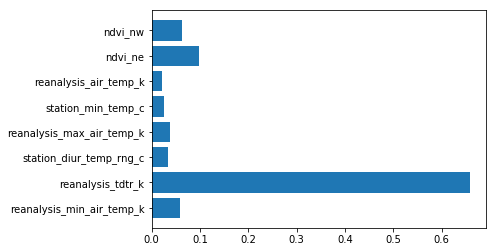

In [75]:
# Visualising feature importances in Decision Tree Classifier (first iteration)
plt.barh(first_features, dtc1_importance)
plt.show()

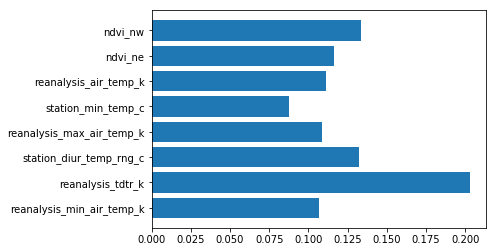

In [76]:
# Visualising feature importances in GBT Classifier (first iteration)
plt.barh(first_features, gbt1_importance)
plt.show()

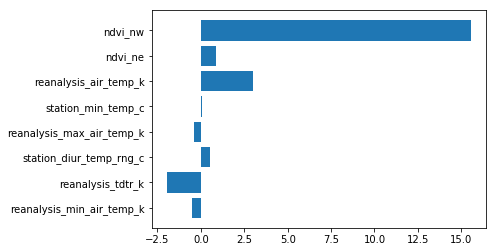

In [77]:
# Visualising correlation polarity in Linear Regression (first iteration)
plt.barh(first_features, lr1_model.coefficients)
plt.show()

#### 8.2.2 Second iteration – visualizing the data, results, models and patterns

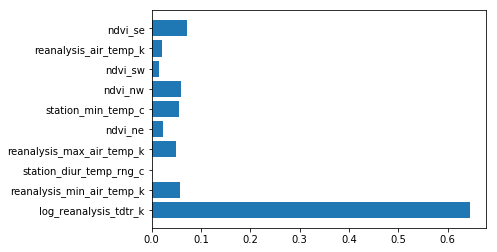

In [78]:
# Visualising feature importances in Decision Tree Classifier (second iteration)
plt.barh(second_features, dtc2_importance)
plt.show()

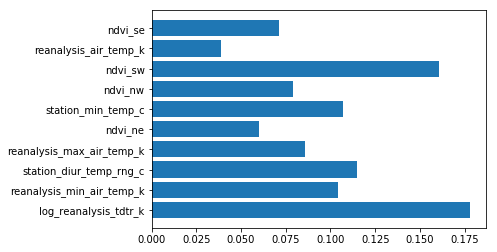

In [79]:
# Visualising feature importances in GBT Classifier (second iteration)
plt.barh(second_features, gbt2_importance)
plt.show()

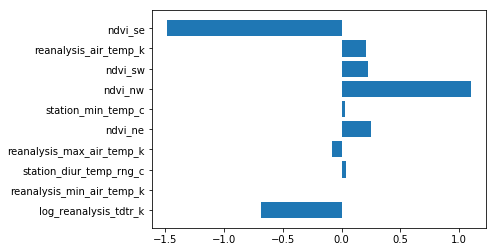

In [80]:
# Visualising correlation polarity in Linear Regression (second iteration)
plt.barh(second_features, lr2_model.coefficients)
plt.show()

#### 8.2.3 Third iteration – visualizing the data, results, models and patterns

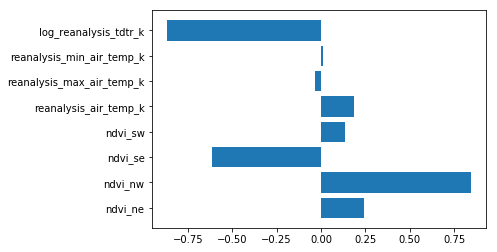

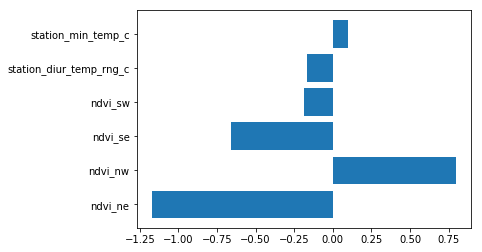

In [81]:
# Visualising correlation polarity in Linear Regression (third iteration)
plt.barh(third_features_reanalysis, lr3r_model.coefficients)
plt.show()
plt.barh(third_features_station, lr3s_model.coefficients)
plt.show()